In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras


In [2]:
data = pd.read_csv("/content/all_stocks_5yr.csv", delimiter=",", on_bad_lines="skip")

print("Dataset Shape:", data.shape)
print(data.sample(7))


Dataset Shape: (619040, 7)
              date    open    high       low   close   volume  Name
582182  2016-06-15   91.35   91.98   90.4000   90.84  1083223  VRTX
265891  2016-02-16   27.00   27.73   26.8050   27.47  5101828   HBI
206593  2016-07-26   24.93   25.29   24.9000   25.24  2984748  ETFC
616343  2017-05-24  117.90  119.19  117.4000  119.10  1165057   ZBH
151015  2017-01-10   56.43   56.93   55.9350   56.66  4710677  CTSH
207595  2015-07-20   65.04   65.51   64.9500   65.25  1659398   ETN
37325   2017-02-13  127.22  128.15  126.0397  127.77  3021091  ALXN


In [3]:
data.info()

data["date"] = pd.to_datetime(data["date"])
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    61

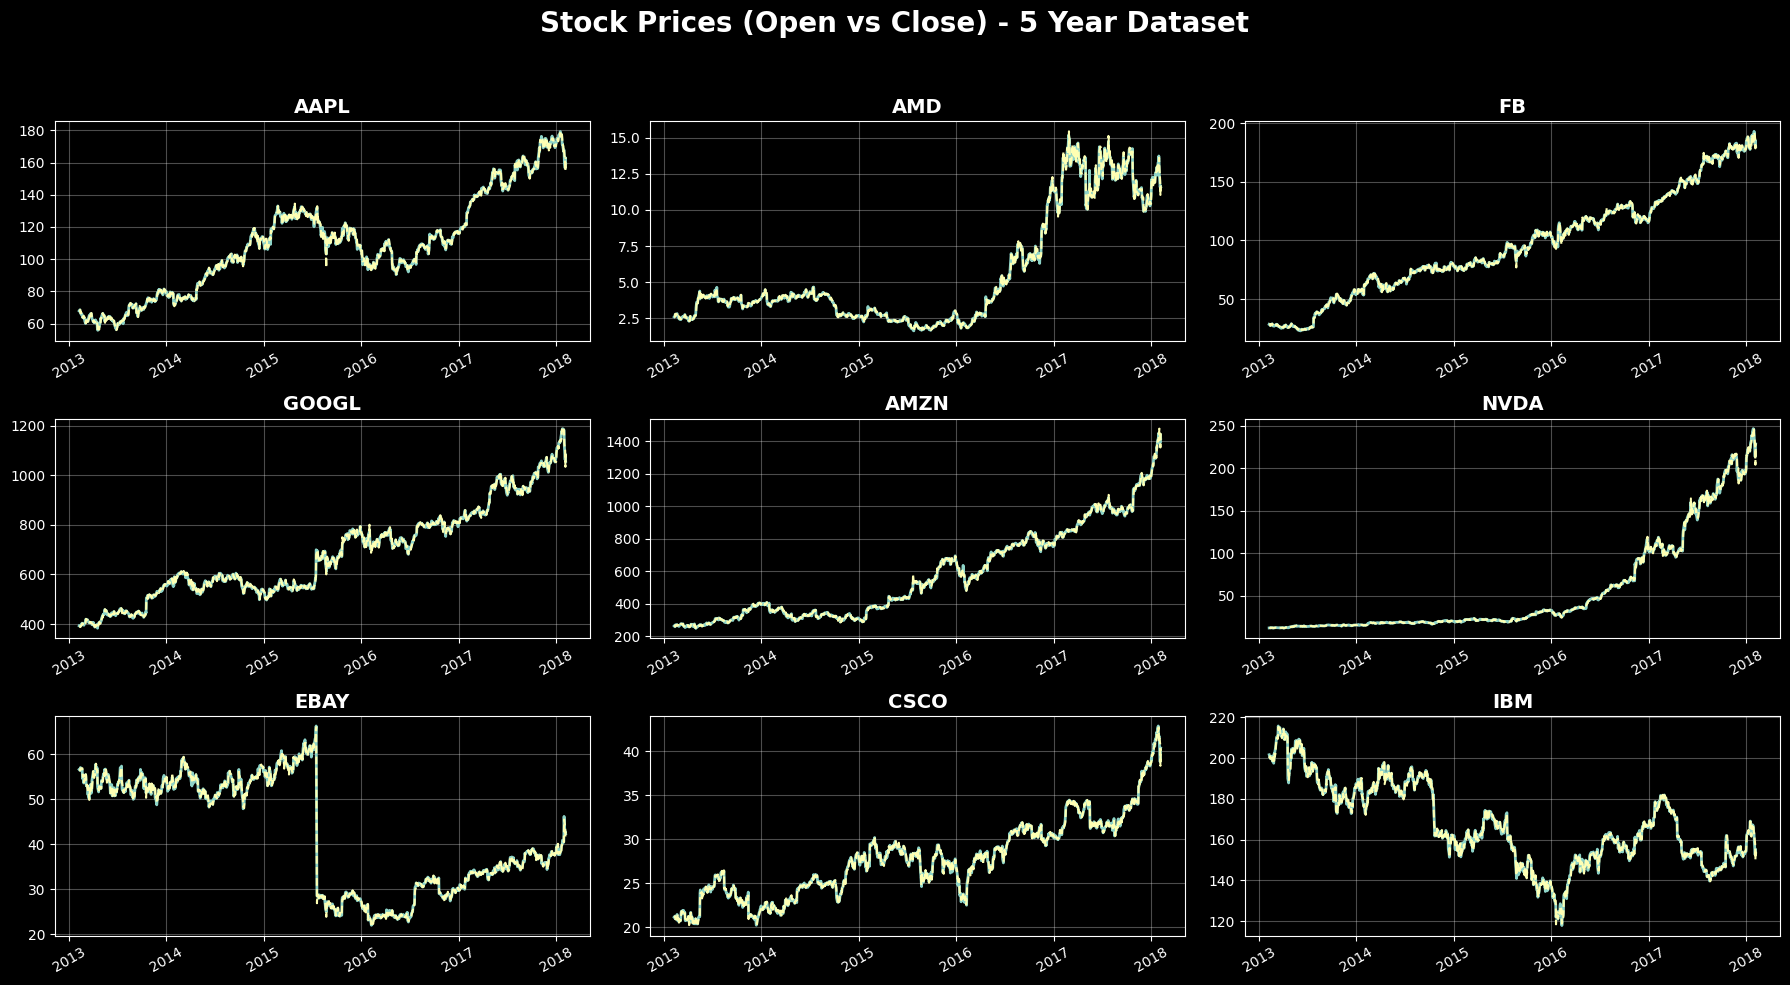

In [4]:
plt.style.use("dark_background")

companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle("Stock Prices (Open vs Close) - 5 Year Dataset", fontsize=20, fontweight="bold")

for ax, company in zip(axes.flatten(), companies):
    c = data[data["Name"] == company]

    ax.plot(c["date"], c["close"], label="Close", linewidth=2)
    ax.plot(c["date"], c["open"], label="Open", linewidth=1.5, linestyle="--")

    ax.set_title(company, fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [5]:
company_name = "AAPL"

stock = data[data["Name"] == company_name].copy()
stock = stock.sort_values("date")

print(stock.shape)
stock.head()


(1259, 7)


,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


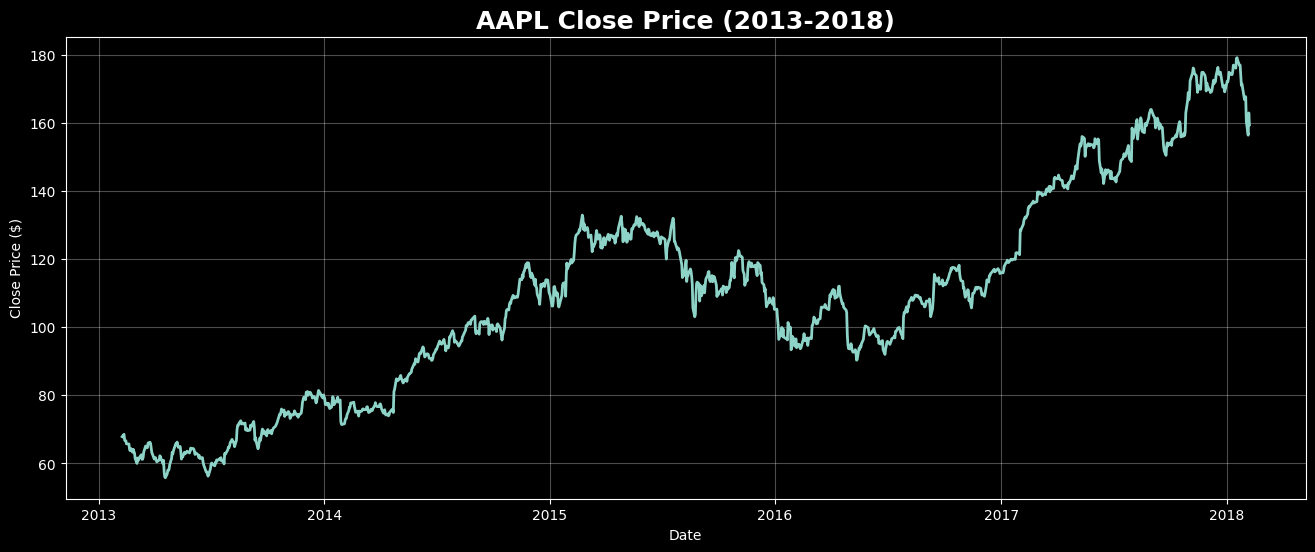

In [6]:
plt.style.use("dark_background")

plt.figure(figsize=(16, 6))
plt.plot(stock["date"], stock["close"], linewidth=2)
plt.title(f"{company_name} Close Price (2013-2018)", fontsize=18, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
close_data = stock.filter(["close"])
dataset = close_data.values

training_size = int(np.ceil(len(dataset) * 0.95))

print("Total Data:", len(dataset))
print("Training Size:", training_size)


Total Data: 1259
Training Size: 1197


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [9]:
train_data = scaled_data[:training_size]

x_train = []
y_train = []

window_size = 60

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i - window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

# reshape for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (1137, 60, 1)
y_train shape: (1137,)


In [10]:
model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    keras.layers.Dropout(0.2),

    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0624
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 9/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 10/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 11/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 12/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 13/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 14/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 15/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 16/25
36

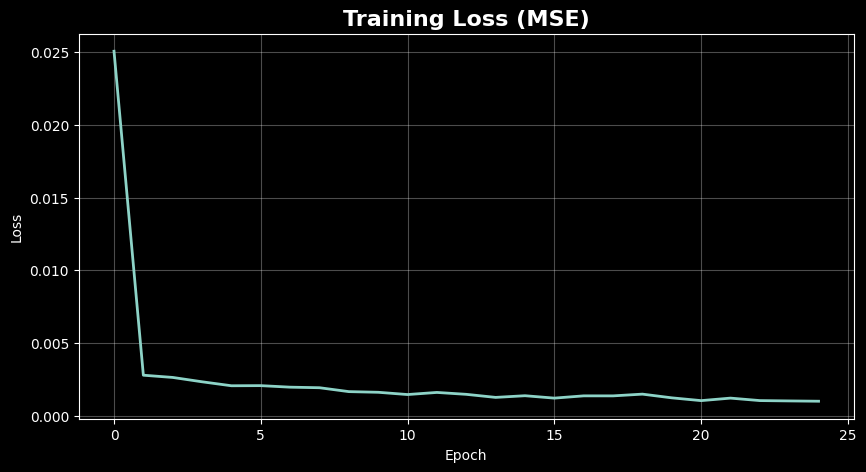

In [12]:
plt.style.use("dark_background")

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], linewidth=2)
plt.title("Training Loss (MSE)", fontsize=16, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
test_data = scaled_data[training_size - window_size:]

x_test = []
y_test = dataset[training_size:]  # original close prices

for i in range(window_size, len(test_data)):
    x_test.append(test_data[i - window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_test shape: (62, 60, 1)
y_test shape: (62, 1)


In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print("Predictions shape:", predictions.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step
Predictions shape: (62, 1)


In [15]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)


RMSE: 4.692166076324883


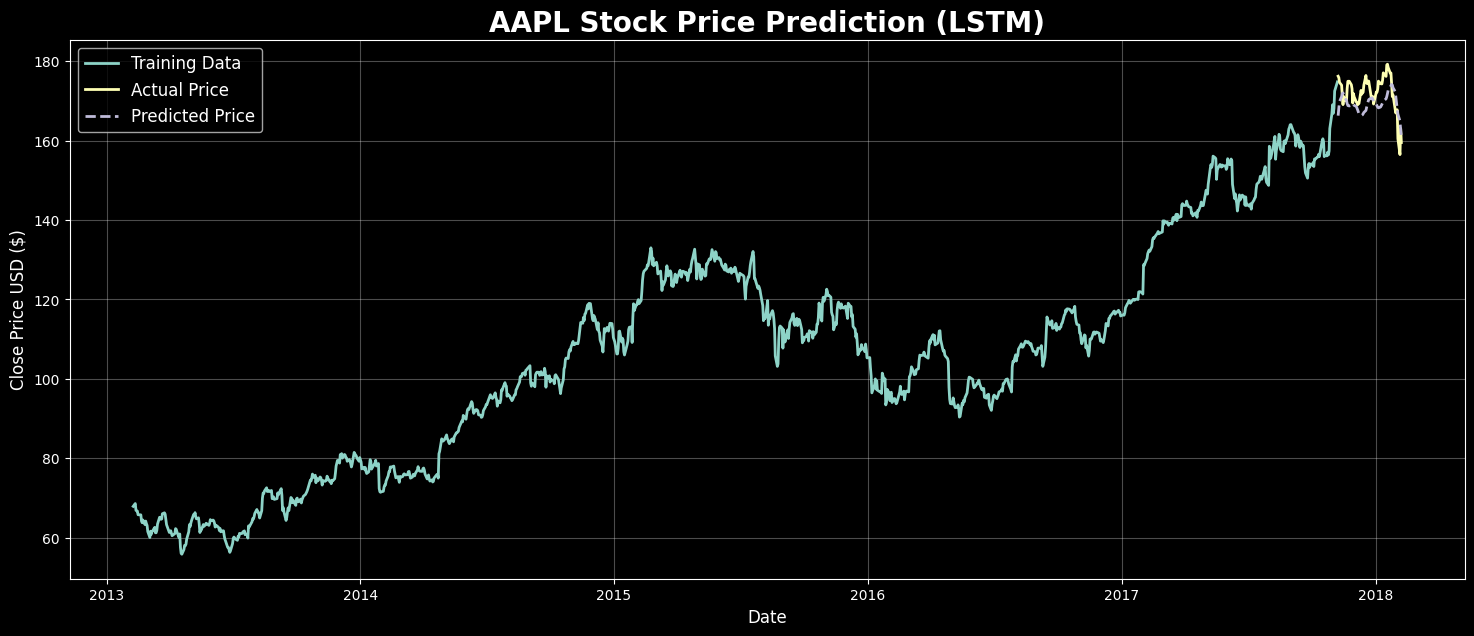

In [16]:
train = stock.iloc[:training_size].copy()
test = stock.iloc[training_size:].copy()

test["Predictions"] = predictions

plt.style.use("dark_background")

plt.figure(figsize=(18, 7))
plt.title(f"{company_name} Stock Price Prediction (LSTM)", fontsize=20, fontweight="bold")

plt.plot(train["date"], train["close"], label="Training Data", linewidth=2)
plt.plot(test["date"], test["close"], label="Actual Price", linewidth=2)
plt.plot(test["date"], test["Predictions"], label="Predicted Price", linewidth=2, linestyle="--")

plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price USD ($)", fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.show()


In [17]:
future_days = 30

last_60_days = scaled_data[-window_size:]
future_input = last_60_days.reshape(1, window_size, 1)

future_predictions = []

for _ in range(future_days):
    pred = model.predict(future_input, verbose=0)
    future_predictions.append(pred[0, 0])

    future_input = np.append(future_input[:, 1:, :], [[[pred[0, 0]]]], axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

print("Next 30 days predicted prices:\n", future_predictions[:5])


Next 30 days predicted prices:
 [[159.39656]
 [158.0352 ]
 [156.82213]
 [155.71054]
 [154.67058]]
